In [12]:
'''
Sources::::: 
https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

https://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.
http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- 

'''

'\nSources::::: \nhttps://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk\nhttps://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm\n\nhttps://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.\nhttp://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- \n\n'

In [13]:
import nltk, re, string, random
import matplotlib.pyplot as plt
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, classify, NaiveBayesClassifier
from WNAffect import wnaffect,emotion
from Lexicon import Lexicon
import matplotlib.cm as cm

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def lemmatize_sentence(tokens):
    '''
    lemmatizing words, for e.g 'run', 'ran', 'running' is the same word.
    The lemmatizer conforms similar words to an equivalent form, or is transformed to its root form
    '''
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):
    '''
    Removing stop words like 'is', 'the' etc. lemmatize_sentence() function implementation is 
    reused here.
    '''
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

In [15]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

In [16]:
positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []
stop_words = stopwords.words('english')

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

print(positive_tweet_tokens[500])
print(positive_cleaned_tokens_list[500])

['Dang', 'that', 'is', 'some', 'rad', '@AbzuGame', '#fanart', '!', ':D', 'https://t.co/bI8k8tb9ht']
['dang', 'rad', '#fanart', ':d']


In [17]:
all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)
freq_dist_pos = FreqDist(all_pos_words)
freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_pos.most_common(10))
print(freq_dist_neg.most_common(10))

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]
[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218)]


In [18]:
from Lexicon import Lexicon
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

print(positive_tokens_for_model)
print(negative_tokens_for_model)

#wna = WNAffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#wna = wnaffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#emo = wna.get_emotion('', 'JJ')

emotion_fetcher = Lexicon.Lexicon("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
#print(emotion_fetcher.get_emotion("shout"))
emotions_count_dict = {"anger":0,"anticipation":0,"disgust":0,"fear":0,"joy":0,"negative":0,"positive":0,"sadness":0,"surprise":0,"trust":0,"unclassified":0}

'''
pos_count=0
emotions_list=[]
pos_word_list=[]
for tweet_dict in positive_tokens_for_model:
    for word,tag in pos_tag(tweet_dict):
        pos_word_list.append(word)
    pos_count+=1

print(pos_word_list)

for word in pos_word_list:
    for sentiment in emotion_fetcher.get_emotion(word):
        emotions_count_dict[sentiment]+=1


print(emotions_count_dict)

neg_count=0
#for tweet_dict in negative_tokens_for_model:
    #neg_count+=1

fig = plt.figure()
tweet_type = ['Positive','Negative']
tweet_counts = [pos_count,neg_count]
ax = fig.add_axes([0,0,1,1])
ax.bar(tweet_type,tweet_counts)
plt.show()
'''

<generator object get_tweets_for_model at 0x0000022BA5FE8CC8>
<generator object get_tweets_for_model at 0x0000022BA5FE8BC8>


"\npos_count=0\nemotions_list=[]\npos_word_list=[]\nfor tweet_dict in positive_tokens_for_model:\n    for word,tag in pos_tag(tweet_dict):\n        pos_word_list.append(word)\n    pos_count+=1\n\nprint(pos_word_list)\n\nfor word in pos_word_list:\n    for sentiment in emotion_fetcher.get_emotion(word):\n        emotions_count_dict[sentiment]+=1\n\n\nprint(emotions_count_dict)\n\nneg_count=0\n#for tweet_dict in negative_tokens_for_model:\n    #neg_count+=1\n\nfig = plt.figure()\ntweet_type = ['Positive','Negative']\ntweet_counts = [pos_count,neg_count]\nax = fig.add_axes([0,0,1,1])\nax.bar(tweet_type,tweet_counts)\nplt.show()\n"

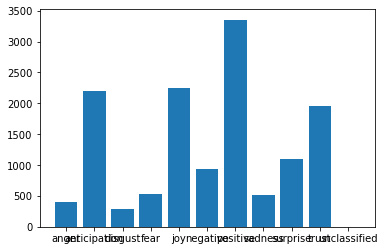

In [19]:
emotions = {'anger': 406, 'anticipation': 2203, 'disgust': 287, 'fear': 534, 'joy': 2248, 'negative': 940, 'positive': 3353, 'sadness': 522, 'surprise': 1096, 'trust': 1949, 'unclassified': 0}

emotions_colors = {'anger': 'red', 'anticipation': 'purple', 'disgust': 'yellow', 'fear': 'indigo', 'joy': 'green', 'negative': 'black', 'positive': 'pink', 'sadness': 'blue', 'surprise': 'maroon', 'trust': 'orange', 'unclassified': 'cyan'}
#labels = list(emotions_colors.keys())
#handles = [plt.Rectangle((1,1),1,1, color=emotions_colors[label]) for label in labels]

plt.bar(range(len(emotions)), list(emotions.values()), align='center')
plt.xticks(range(len(emotions)), list(emotions.keys()))
#plt.legend(handles, labels)
plt.show()

In [20]:
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

print(positive_dataset)
print(negative_dataset)

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

#70:30 split
train_data = dataset[:7000]
test_data = dataset[7000:]   

print(train_data)
print(test_data)

'xx': True}, 'Positive'), ({'bed': True, 'best': True, 'couple': True, 'ever': True, ':)': True}, 'Positive'), ({'favorite': True, 'apple': True, 'sauce': True, ':)': True}, 'Positive'), ({'nice': True, 'holiday': True, 'honey': True, ':-)': True, 'kisses': True}, 'Positive'), ({'follow': True, 'back': True, 'pleasse': True, ':)': True}, 'Positive'), ({'thakyou': True, 'sir': True, ':)': True}, 'Positive'), ({'thank': True, 'beatriz': True, ':)': True}, 'Positive'), ({'rt': True, 'bailona': True, 'group': True, 'chat': True, 'mention': True, 'approve': True, 'fanbase': True, ':)': True}, 'Positive'), ({'party': True, 'cancel': True, ':p': True, '#bajrangibhaijaanhighestweek1': True}, 'Positive'), ({'thanks': True, 'follow': True, ':-)': True, 'hope': True, 'great': True, 'week': True}, 'Positive'), ({'puff': True, 'pastry': True, 'egg': True, 'tart': True, 'hot': True, 'fresh': True, 'oven': True, ':)': True, 'wan': True, 'chai': True, 'mtr': True}, 'Positive'), ({'thank': True, 'follo

NameError: name 'negative_dataset' is not defined

In [ ]:
classifier = NaiveBayesClassifier.train(train_data)

In [ ]:
print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))